<a href="https://colab.research.google.com/github/Dhanush006/DCASE23_Task2_Vehicle_Sound_Event_Detection/blob/main/Cleaned_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import librosa
import librosa.display

# Load Data

In [ ]:
# Mount drive
drive.mount('/content/drive')

# Navigate to data folder
%cd /content/drive/MyDrive/Group\ Project/DCASE23_Task2_Vehicle_Sound_Event_Detection

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection


# Data Prep

In [ ]:
### --- Split Data --- ###
'''
Assigned DCASE23_Task2_Vehicle already gave us created training and testing data sets.
We split the given training set into a training and validation set.

Our split: 67%/16%/16%
Train: 5600
Validation: 1400
Test: 1400
'''

# Paths to saved training and testpickle files
train_pickle_path = "/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/extracted_dataset/train_with_audio.pkl"
test_pickle_path = "/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/extracted_dataset/test_with_audio.pkl"

# Load pickle files
df_train_audio = pd.read_pickle(train_pickle_path)
df_test_audio = pd.read_pickle(test_pickle_path)

# Split training dataset into train and validation set
df_train, df_val = train_test_split(
    df_train_audio, test_size=0.2,
    stratify=df_train_audio["class"], random_state=42
)
df_test = df_test_audio

In [ ]:
df_train['dataset'] = 'train'
df_val['dataset'] = 'validation'
df_test['dataset'] = 'test'

df_full = pd.concat([df_train, df_val, df_test], ignore_index=True)

# EDA
## Descriptive Statistics

In [ ]:
###-- Check Class Distributions --###
'''
Data Distribution is completely even. There are 7 classes, with each class having
1/7th of the data points. This is the same for train, validation and test sets.
'''

# Get count for each class in each data set split
train_class_dist = df_train['class'].value_counts()
val_class_dist = df_val['class'].value_counts()
test_class_dist = df_test['class'].value_counts()

# Create dataframe to hold above values
class_dist = pd.DataFrame({'Training Set': train_class_dist, 'Validation Set': val_class_dist, 'Testing Set': test_class_dist})

# Add class and row totals
class_dist['Total'] = class_dist.sum(axis=1)
class_dist_totals  = pd.concat([class_dist, class_dist.sum(axis=0).rename('Total').to_frame().T])

# Display
print('Data Distribution')
class_dist_totals



Data Distribution


Training Set  Validation Set  Testing Set  Total
ToyCar             800             200          200   1200
ToyTrain           800             200          200   1200
bearing            800             200          200   1200
fan                800             200          200   1200
gearbox            800             200          200   1200
slider             800             200          200   1200
valve              800             200          200   1200
Total             5600            1400         1400   8400

In [ ]:
###-- Descriptive Data Statistics --###
'''
Notes:

The following columns include null values: 'd2p','d2v','d3p', 'd3v'. This is not
an error, if you look at dataset description, the d*p and d*v columns represent
parameter and parameter values. Some class types don't have all 3 parameters
filled out.

'''

##-- General Data Info --##
# Training Set
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8400 entries, 0 to 8399
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   d1p                                  8400 non-null   object 
 1   d1v                                  8400 non-null   object 
 2   path                                 8400 non-null   object 
 3   class                                8400 non-null   object 
 4   domain                               8400 non-null   object 
 5   section                              8400 non-null   int64  
 6   label                                8400 non-null   object 
 7   d2p                                  6000 non-null   object 
 8   d2v                                  6000 non-null   object 
 9   d3p                                  2400 non-null   object 
 10  d3v                                  2400 non-null   float64
 11  audio_path                    

In [ ]:
##-- Domain and Label Distributions --##
'''
Notes:
Train, test and validation set all include 'source' and 'target' domain.
Test data set is evenly split between 'source' and 'target' domain while the test
and validation set contain about 1% 'target' domain.


Train, test and validation set include 'normal' label.
Only test set includes 'anomaly' label.
'''

cat_cols = ['domain','label']

# Frequency counts
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df_full.groupby('dataset')[col].value_counts(), '\n')
    print(df_full.groupby('dataset')[col].value_counts(normalize=True))



Column: domain
dataset     domain
test        source     700
            target     700
train       source    5543
            target      57
validation  source    1387
            target      13
Name: count, dtype: int64 

dataset     domain
test        source    0.500000
            target    0.500000
train       source    0.989821
            target    0.010179
validation  source    0.990714
            target    0.009286
Name: proportion, dtype: float64

Column: label
dataset     label  
test        anomaly     700
            normal      700
train       normal     5600
validation  normal     1400
Name: count, dtype: int64 

dataset     label  
test        anomaly    0.5
            normal     0.5
train       normal     1.0
validation  normal     1.0
Name: proportion, dtype: float64


## Data Visualization

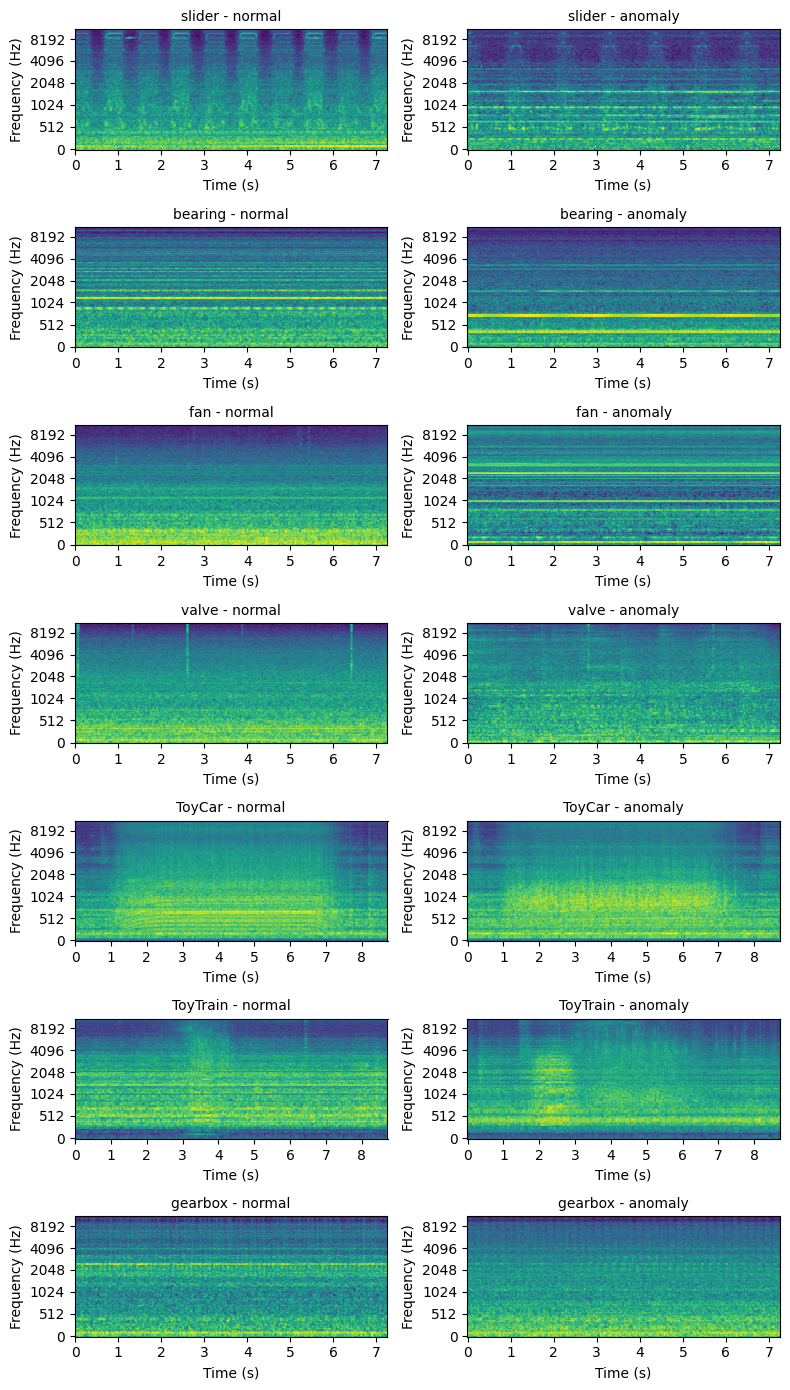

In [ ]:
###-- Mel Spectrograms --###

df_mel = df_full

def gen_mel_spectrogram(audio_array):
    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio_array)

    # Convert to decibel scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return mel_spec_db

# Get unique classes (7) and labels (2)
classes = df_mel['class'].unique()
labels = df_mel['label'].unique()

# Create subplots (row for each class, col fro each label)
fig, axes = plt.subplots(len(classes), len(labels), figsize=(8, 14))

# Generate mel spectrogramns for each class-label combo
for i, cls in enumerate(classes):
    for j, lbl in enumerate(labels):
        # Get data for class-label combo
        subset = df_mel[(df_mel['class'] == cls) & (df_mel['label'] == lbl)]

        # Get audio array
        sample = subset.iloc[0]
        audio_array = sample['audio_array']

        # Gen mel spectrogram
        mel_spec_db = gen_mel_spectrogram(audio_array)
        # print(f"Mel spectrogram shape: {mel_spec_db.shape}")

        # Plot spectrogram
        ax = axes[i, j]
        img = librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', ax=ax, cmap='viridis')
        ax.set_title(f"{cls} - {lbl}", fontsize=10)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()


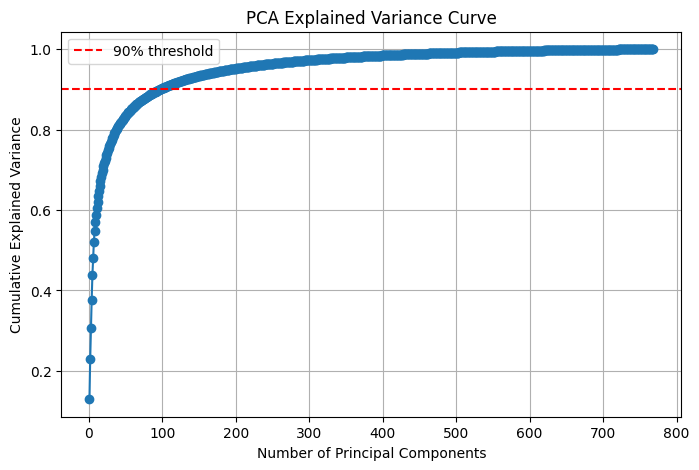

Number of components to capture ≥90% variance: 97


In [ ]:
###-- PCA --###
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Convert list-like embeddings to 2D numpy array
X = np.stack(df_train_audio['ast-finetuned-audioset-10-10-0.4593'].values)

# Reshape the array to 2D
X = X.reshape(X.shape[0], -1)

# Scale for uniform variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA on scaled embeddings
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Curve')
plt.legend()
plt.grid(True)
plt.show()

# Find number of components that explain >=90% variance
n_components_90 = np.argmax(cum_var >= 0.9) + 1
print(f"Number of components to capture ≥90% variance: {n_components_90}")

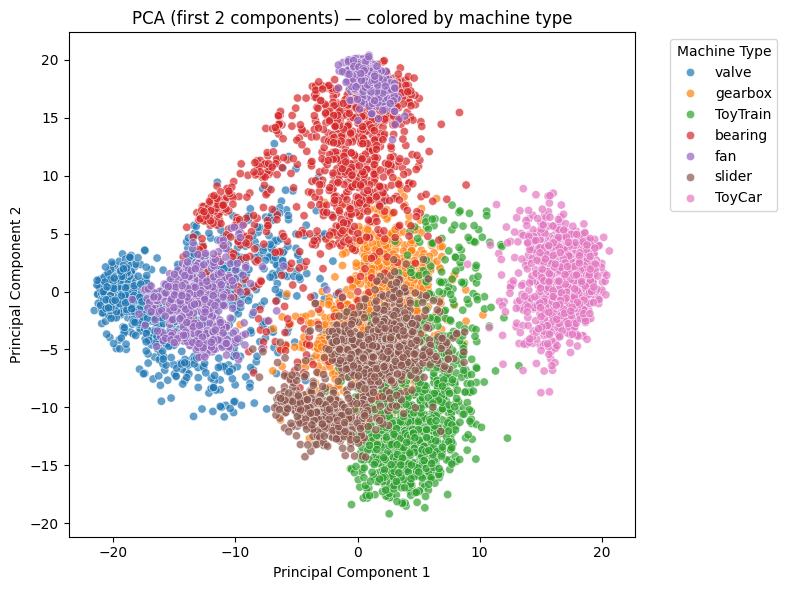

In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame with PCA components + class labels
df_pca = pd.DataFrame({
    'PC1': X_pca_full[:, 0],
    'PC2': X_pca_full[:, 1],
    'class': df_train_audio['class'].values
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='class',  # this will show machine names
    palette='tab10',
    alpha=0.7
)
plt.title('PCA (first 2 components) — colored by machine type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Machine Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Model Selection for Machine-Type Classification

## K-Means/GMM/Agglomerative Clustering


In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_true = df_train_audio['class'].values
def evaluate_clustering(model, X, y_true, model_name):
    # Fit model and get cluster labels
    if hasattr(model, "fit_predict"):
        y_pred = model.fit_predict(X)
    else:
        model.fit(X)
        y_pred = model.predict(X)

    # Internal & external metrics
    sil_score = silhouette_score(X, y_pred) if len(set(y_pred)) > 1 else -1
    ari = adjusted_rand_score(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Adjusted Rand Index: {ari:.3f}\n")

    return y_pred

In [ ]:
# KMeans
kmeans = KMeans(n_clusters=len(np.unique(y_true)), random_state=42)
y_kmeans = evaluate_clustering(kmeans, X_pca_full, y_true, "K-Means")

# GMM
gmm = GaussianMixture(n_components=len(np.unique(y_true)), random_state=42)
y_gmm = evaluate_clustering(gmm, X_pca_full, y_true, "Gaussian Mixture Model")

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=len(np.unique(y_true)))
y_agglo = evaluate_clustering(agglo, X_pca_full, y_true, "Agglomerative Clustering")

=== K-Means ===
Silhouette Score: 0.173
Adjusted Rand Index: 0.621

=== Gaussian Mixture Model ===
Silhouette Score: 0.173
Adjusted Rand Index: 0.621

=== Agglomerative Clustering ===
Silhouette Score: 0.195
Adjusted Rand Index: 0.754



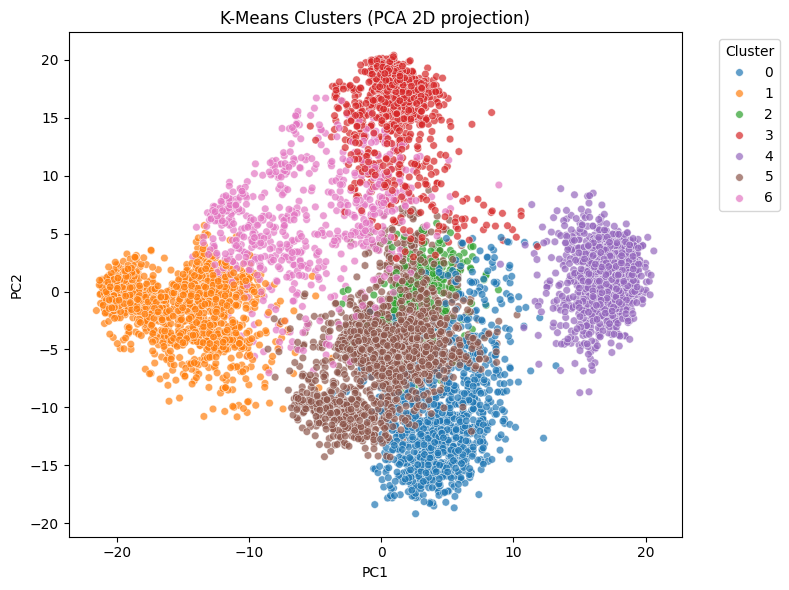

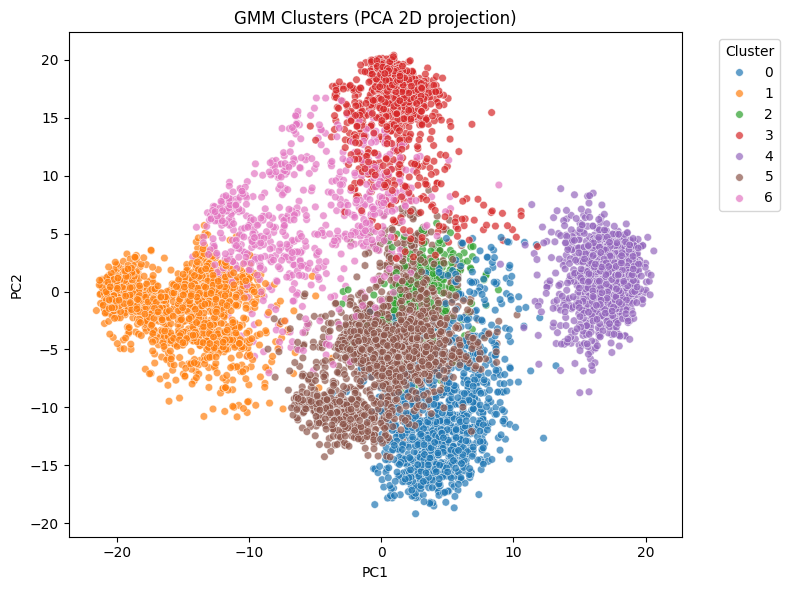

In [ ]:
def plot_clusters(X_2d, labels, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_2d[:,0], y=X_2d[:,1],
        hue=labels, palette='tab10', s=30, alpha=0.7
    )
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Visualize KMeans & GMM clusters
plot_clusters(X_pca_full[:, :2], y_kmeans, "K-Means Clusters (PCA 2D projection)")
plot_clusters(X_pca_full[:, :2], y_gmm, "GMM Clusters (PCA 2D projection)")

## Bisecting K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

def bisecting_kmeans(X, y_true, n_clusters=7, max_iter=10):
    # Initialize with all data in one cluster (labeled 0)
    clusters = [X]
    labels = np.zeros(X.shape[0], dtype=int)
    cluster_indices = [np.arange(X.shape[0])] # Store indices corresponding to each cluster
    current_label_counter = 0

    while len(clusters) < n_clusters and current_label_counter < max_iter:
        # Pick the cluster with largest size to split
        largest_cluster_idx_in_list = np.argmax([c.shape[0] for c in clusters])
        cluster_to_split = clusters.pop(largest_cluster_idx_in_list)
        indices_to_split = cluster_indices.pop(largest_cluster_idx_in_list)

        if cluster_to_split.shape[0] == 0: # Avoid trying to split an empty cluster
            continue

        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit(cluster_to_split) # Added n_init
        split_labels = kmeans.labels_

        # Split the indices of the cluster being split
        indices_split_0 = indices_to_split[split_labels == 0]
        indices_split_1 = indices_to_split[split_labels == 1]

        # Assign new labels
        labels[indices_split_0] = current_label_counter
        labels[indices_split_1] = len(clusters) # Assign the next available label

        # Add new clusters and their indices to the lists
        clusters.append(X[indices_split_0])
        clusters.append(X[indices_split_1])
        cluster_indices.append(indices_split_0)
        cluster_indices.append(indices_split_1)

        current_label_counter += 1


    sil = silhouette_score(X, labels) if len(set(labels)) > 1 else -1 # Handle case with only one cluster
    ari = adjusted_rand_score(y_true, labels)
    print(f"Bisecting K-Means — Silhouette: {sil:.3f}, ARI: {ari:.3f}")
    return labels

_ = bisecting_kmeans(X_pca_full, y_true, n_clusters=7)

Bisecting K-Means — Silhouette: 0.140, ARI: 0.517


## HDBSCAN

In [ ]:
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

hdb = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=5)
y_hdb = hdb.fit_predict(X_pca_full)

sil = silhouette_score(X_pca_full, y_hdb)
ari = adjusted_rand_score(y_true, y_hdb)
print(f"HDBSCAN — Silhouette: {sil:.3f}, ARI: {ari:.3f}")

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN — Silhouette: 0.156, ARI: 0.547


## Naive Bayes/Decision Tree/Random Forest/SVM/KNN

In [ ]:
# Needed
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

X_train = np.stack(df_train_audio['ast-finetuned-audioset-10-10-0.4593'].values).reshape(df_train_audio.shape[0], -1)
y_train = df_train_audio['class'].values
X_test = np.stack(df_test_audio['ast-finetuned-audioset-10-10-0.4593'].values).reshape(df_test_audio.shape[0], -1)
y_test = df_test_audio['class'].values
# Define classifiers
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train & evaluate
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Macro F1-score: {macro_f1:.3f}")
    print(f"Confusion Matrix:\n{cm}\n")

=== Naive Bayes ===
Accuracy: 0.923
Macro F1-score: 0.918
Confusion Matrix:
[[200   0   0   0   0   0   0]
 [  0 197   3   0   0   0   0]
 [  0   2 194   0   0   0   4]
 [  0   0  50 112  10  24   4]
 [  0   0   1   0 197   2   0]
 [  0   0   2   0   0 198   0]
 [  0   1   5   0   0   0 194]]

=== Decision Tree ===
Accuracy: 0.870
Macro F1-score: 0.869
Confusion Matrix:
[[199   0   0   0   1   0   0]
 [  2 175   2   5   6   5   5]
 [  0   4 163  12   4   2  15]
 [  1  18  30 140   2   4   5]
 [  1   0   6   9 175   5   4]
 [  0   3   8   0  11 175   3]
 [  0   2   3   0   3   1 191]]

=== Random Forest ===
Accuracy: 0.962
Macro F1-score: 0.962
Confusion Matrix:
[[200   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  0   3  37 155   3   2   0]
 [  0   0   2   1 197   0   0]
 [  0   0   3   0   1 196   0]
 [  0   1   0   0   0   0 199]]

=== SVM ===
Accuracy: 0.986
Macro F1-score: 0.986
Confusion Matrix:
[[200   0   0   0   0   0   0]
 [  0 200   

## CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# ===========================================================
# 1. Dataset Class: takes DataFrame directly
# ===========================================================
class AudioFrameDataset(Dataset):
    def __init__(self, df, sr_col='sample_rate', audio_col='audio_array', label_col='class', n_mels=128, pad_to_length=1024):
        self.df = df.reset_index(drop=True)
        self.audio_col = audio_col
        self.sr_col = sr_col
        self.label_col = label_col
        self.n_mels = n_mels
        self.pad_to_length = pad_to_length # Added padding length attribute


        # Handle potential missing labels in test set by fitting on combined data
        all_labels = pd.concat([df_train_audio['class'], df_test_audio['class']]).unique()
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(all_labels)
        self.labels = self.label_encoder.transform(df[label_col])

        # Check if df is empty before accessing iloc[0]
        if not self.df.empty:
            self.mel_transform = nn.Sequential(
                MelSpectrogram(
                    sample_rate=int(self.df[self.sr_col].iloc[0]),
                    n_fft=1024,
                    hop_length=256,
                    n_mels=n_mels
                ),
                AmplitudeToDB()
            )
        else:
            # Handle empty DataFrame case: set mel_transform to None or use default sample rate
            # For now, let's raise an error or handle more robustly if empty df is expected
            raise ValueError("Input DataFrame is empty. Cannot initialize MelSpectrogram.")


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.mel_transform is None:
             raise IndexError("Cannot get item from an empty dataset. MelTransform is not initialized.")

        audio = np.array(self.df[self.audio_col].iloc[idx], dtype=np.float32)
        audio = torch.tensor(audio).unsqueeze(0)  # (1, n_samples)
        mel = self.mel_transform(audio)           # (1, n_mels, time)

        # Pad or truncate the mel spectrogram to a fixed length
        current_length = mel.size(2)
        if current_length < self.pad_to_length:
            padding = self.pad_to_length - current_length
            mel = F.pad(mel, (0, padding))
        elif current_length > self.pad_to_length:
            mel = mel[:, :, :self.pad_to_length]

        mel = (mel - mel.mean()) / (mel.std() + 1e-6)  # normalize
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# ===========================================================
# 2. Simple CNN Model
# ===========================================================
class AudioCNN(nn.Module):
    def __init__(self, n_classes, n_mels=128, pad_to_length=1024): # Added n_mels and pad_to_length
        super(AudioCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # Calculate the output size after convolutional layers and pooling
        # Assuming pooling layers of kernel size 2 and stride 2
        conv_output_height = n_mels // (2**3)
        conv_output_width = pad_to_length // (2**3)
        flattened_size = 64 * conv_output_height * conv_output_width


        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 256), # Adjusted input size
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

# ===========================================================
# 3. Training / Evaluation Functions
# ===========================================================
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for mel, label in dataloader:
        mel, label = mel.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(mel)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * mel.size(0)
        correct += (out.argmax(1) == label).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for mel, label in dataloader:
            mel, label = mel.to(device), label.to(device)
            out = model(mel)
            loss = criterion(out, label)
            total_loss += loss.item() * mel.size(0)
            correct += (out.argmax(1) == label).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

# ===========================================================
# 4. Modified Train/Test Split (with anomalies)
# ===========================================================
def prepare_train_test_with_anomalies(df_train_audio, df_test_audio):
    """
    df_train_audio → only normal samples
    df_test_audio → both normal + anomalous samples
                    identified by 'label' column ('anomaly' = anomaly)
    """

    df_anomalies = df_test_audio[df_test_audio["label"] == "anomaly"].copy() # Ensure we work on a copy
    df_normals_test = df_test_audio[df_test_audio["label"] == "normal"].copy() # Ensure we work on a copy


    # Split anomalies: half go into train, half remain for test
    if not df_anomalies.empty:
        df_anomalies_train, df_anomalies_val = train_test_split(df_anomalies, test_size=0.5, random_state=42)
    else:
        print("No anomalies found in the test set.")
        # Create empty dataframes with the same columns as df_test_audio
        df_anomalies_train = pd.DataFrame(columns=df_test_audio.columns)
        df_anomalies_val = pd.DataFrame(columns=df_test_audio.columns)


    df_train_final = pd.concat([df_train_audio, df_anomalies_train]).reset_index(drop=True)
    df_test_final = pd.concat([df_normals_test, df_anomalies_val]).reset_index(drop=True)


    print(f"Train: {df_train_final.shape}, Test: {df_test_final.shape}")
    print(f"Train anomalies: {(df_train_final['label'] == 'anomaly').sum()}")
    print(f"Test anomalies: {(df_test_final['label'] == 'anomaly').sum()}")


    return df_train_final, df_test_final

# ===========================================================
# 5. Train & Evaluate Pipeline
# ===========================================================
def run_cnn_training(df_train_audio, df_test_audio, batch_size=32, epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- include anomalies into train set
    df_train_final, df_test_final = prepare_train_test_with_anomalies(df_train_audio, df_test_audio)

    train_ds = AudioFrameDataset(df_train_final)
    test_ds = AudioFrameDataset(df_test_final)
    n_classes = len(np.unique(pd.concat([df_train_final["class"], df_test_final["class"]]))) # Correct number of classes

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Pass n_mels and pad_to_length to the model constructor
    model = AudioCNN(n_classes=n_classes, n_mels=train_ds.n_mels, pad_to_length=train_ds.pad_to_length).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print(f"Training on {device} for {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_dl, optimizer, criterion, device)
        te_loss, te_acc = eval_epoch(model, test_dl, criterion, device)
        print(f"Epoch {epoch:02d} | Train Loss={tr_loss:.4f} Acc={tr_acc:.3f} | Test Loss={te_loss:.4f} Acc={te_acc:.3f}")

    return model, train_ds.label_encoder

In [ ]:
# ===========================================================
# 6. Run the training
# ===========================================================
model, label_encoder = run_cnn_training(df_train_audio, df_test_audio, batch_size=32, epochs=15)

Train: (7350, 21), Test: (1050, 21)
Train anomalies: 350
Test anomalies: 350
Training on cuda for 15 epochs...
Epoch 01 | Train Loss=1.1700 Acc=0.884 | Test Loss=0.1463 Acc=0.935
Epoch 02 | Train Loss=0.1306 Acc=0.959 | Test Loss=0.2504 Acc=0.935
Epoch 03 | Train Loss=0.0708 Acc=0.975 | Test Loss=0.0464 Acc=0.984
Epoch 04 | Train Loss=0.0742 Acc=0.975 | Test Loss=0.0324 Acc=0.991
Epoch 05 | Train Loss=0.0491 Acc=0.983 | Test Loss=0.0702 Acc=0.984
Epoch 06 | Train Loss=0.1524 Acc=0.968 | Test Loss=0.0406 Acc=0.986
Epoch 07 | Train Loss=0.0654 Acc=0.979 | Test Loss=0.0549 Acc=0.986
Epoch 08 | Train Loss=0.1574 Acc=0.967 | Test Loss=0.0237 Acc=0.991
Epoch 09 | Train Loss=0.0386 Acc=0.989 | Test Loss=0.0540 Acc=0.986
Epoch 10 | Train Loss=0.0503 Acc=0.985 | Test Loss=0.0855 Acc=0.979
Epoch 11 | Train Loss=0.0348 Acc=0.991 | Test Loss=0.0456 Acc=0.991
Epoch 12 | Train Loss=0.0214 Acc=0.995 | Test Loss=0.0236 Acc=0.997
Epoch 13 | Train Loss=0.0308 Acc=0.992 | Test Loss=0.0383 Acc=0.990
Epoch

In [ ]:
# Save model weights and label encoder
torch.save(model.state_dict(), "audio_cnn_weights.pth")

import joblib
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
# Rebuild same model architecture first
import joblib
label_encoder = joblib.load("label_encoder.pkl")
n_classes = len(label_encoder.classes_)
model_loaded = AudioCNN(n_classes)
model_loaded.load_state_dict(torch.load("audio_cnn_weights.pth", map_location="cpu"))
model_loaded.eval()

AudioCNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=131072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256

## AudioResNet(ResNet-Inspired CNN for Machine-Type Classification)

In [ ]:
#Needed
import torch
import numpy as np
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
def compute_max_spec_width(df, sr_col='sample_rate', audio_col='audio_array',
                           n_fft=1024, hop_length=256, n_mels=128):

    # Initialize the Mel transform
    sample_rate = int(df[sr_col].iloc[0])
    mel_tf = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    mel_db = AmplitudeToDB()

    max_width = 0
    for i in range(len(df)):
        audio = np.array(df[audio_col].iloc[i], dtype=np.float32)
        audio = torch.tensor(audio).unsqueeze(0)  # (1, n_samples)

        mel = mel_tf(audio)
        mel = mel_db(mel)

        width = mel.size(2)
        if width > max_width:
            max_width = width

    return max_width
pad_len_train = compute_max_spec_width(df_train_audio)
pad_len_test = compute_max_spec_width(df_test_audio)
pad_to_length = max(pad_len_train, pad_len_test)
print("Final pad_to_length =", pad_to_length)

Final pad_to_length = 751


In [ ]:
# ===========================================================
# TRAINING PIPELINE WITH:
# - OneCycleLR
# - Gradient clipping
# - Early stopping
# - Metric tracking
# - Training/Validation plots
# ===========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ===========================================================
# 1. Dataset Class
# ===========================================================
class AudioFrameDataset(Dataset):
    def __init__(self, df, sr_col='sample_rate', audio_col='audio_array',
                 label_col='class', n_mels=128, pad_to_length=768):

        self.df = df.reset_index(drop=True)
        self.audio_col = audio_col
        self.sr_col = sr_col
        self.label_col = label_col
        self.n_mels = n_mels
        self.pad_to_length = pad_to_length

        global LABEL_ENCODER
        self.labels = LABEL_ENCODER.transform(df[label_col])

        self.mel_transform = nn.Sequential(
            MelSpectrogram(
                sample_rate=int(self.df[self.sr_col].iloc[0]),
                n_fft=1024,
                hop_length=256,
                n_mels=n_mels
            ),
            AmplitudeToDB()
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      audio = np.array(self.df[self.audio_col].iloc[idx], dtype=np.float32)
      audio = torch.tensor(audio).unsqueeze(0)
      mel = self.mel_transform(audio)

      L = mel.size(2)
      if L < self.pad_to_length:
          pad_len = self.pad_to_length - L
          # Mirror (reflect) padding
          mel = F.pad(mel, (0, pad_len), mode="reflect")
      elif L > self.pad_to_length:
          mel = mel[:, :, :self.pad_to_length]

      # Normalize
      mel = (mel - mel.mean()) / (mel.std() + 1e-6)

      # Convert 1-channel → 3-channel for PADIM compatibility
      mel = mel.repeat(3, 1, 1)  # [3, n_mels, pad_length]

      label = torch.tensor(self.labels[idx], dtype=torch.long)
      return mel, label


# ===========================================================
# 2. ResNet-Inspired CNN
# ===========================================================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(identity)

        return self.relu(out)


class AudioResNet(nn.Module):
    def __init__(self, n_classes, n_mels=128, pad_to_length=768):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 7, 2, 3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
        )

        self.layer1 = self._make_layer(32, 64, 2, 2)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, n_classes)

    def _make_layer(self, in_c, out_c, blocks, stride):
        layers = [ResidualBlock(in_c, out_c, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_c, out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.flatten(1)
        return self.fc(x)

    def extract_embedding(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.flatten(1)  # 256-dimensional vector
        return x



# ===========================================================
# 3. Training & Evaluation
# ===========================================================
def train_epoch(model, loader, optimizer, scheduler, criterion, device, grad_clip=1.0):
    model.train()
    total_loss, correct = 0, 0

    for mel, label in loader:
        mel, label = mel.to(device), label.to(device)

        optimizer.zero_grad()
        logits = model(mel)
        loss = criterion(logits, label)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        scheduler.step()  # <-- OneCycleLR updates every batch

        total_loss += loss.item() * mel.size(0)
        correct += (logits.argmax(1) == label).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for mel, label in loader:
            mel, label = mel.to(device), label.to(device)
            logits = model(mel)
            loss = criterion(logits, label)
            total_loss += loss.item() * mel.size(0)
            correct += (logits.argmax(1) == label).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


# ===========================================================
# 4. Main Training Function With OneCycleLR
# ===========================================================
def run_cnn_training(df_train_audio, df_test_audio,
                     batch_size=32, epochs=20, pad_length=768):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    global LABEL_ENCODER
    LABEL_ENCODER = LabelEncoder()
    LABEL_ENCODER.fit(pd.concat([df_train_audio["class"], df_test_audio["class"]]))

    df_train, df_val = train_test_split(
        df_train_audio, test_size=0.2,
        stratify=df_train_audio["class"], random_state=42
    )
    df_test = df_test_audio

    train_ds = AudioFrameDataset(df_train, pad_to_length=pad_length)
    val_ds   = AudioFrameDataset(df_val, pad_to_length=pad_length)
    test_ds  = AudioFrameDataset(df_test, pad_to_length=pad_length)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size)

    n_classes = len(LABEL_ENCODER.classes_)

    model = AudioResNet(n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=1e-3, weight_decay=1e-4)

    # ======================================================
    # ONE CYCLE LR
    # ======================================================
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-3,
        epochs=epochs,
        steps_per_epoch=len(train_dl),
        pct_start=0.3,
        anneal_strategy="cos",
        div_factor=25,
        final_div_factor=1e4,
    )

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = float("inf")
    patience = 6
    wait = 0

    print("\n Training Started...\n")
    for epoch in range(1, epochs + 1):

        train_loss, train_acc = train_epoch(
            model, train_dl, optimizer, scheduler, criterion, device
        )
        val_loss, val_acc = eval_epoch(model, val_dl, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}")

        # EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), "best_audio_cnn.pth")
        else:
            wait += 1
            if wait >= patience:
                print("\n Early stopping triggered!")
                break

    print("\nLoading best model...")
    model.load_state_dict(torch.load("best_audio_cnn.pth"))

    # Final test performance
    test_loss, test_acc = eval_epoch(model, test_dl, criterion, device)
    print(f"\n Final Test Loss={test_loss:.4f}, Test Acc={test_acc:.3f}")

    # ======================================================
    #  PLOT TRAINING CURVES
    # ======================================================
    epochs_range = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history["train_acc"], label="Train Acc")
    plt.plot(epochs_range, history["val_acc"], label="Val Acc")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.show()

    return model, history


 Training Started...

Epoch 01 | Train Loss: 0.1425 Acc: 0.952 | Val Loss: 0.2147 Acc: 0.930
Epoch 02 | Train Loss: 0.0683 Acc: 0.980 | Val Loss: 0.1237 Acc: 0.961
Epoch 03 | Train Loss: 0.0643 Acc: 0.981 | Val Loss: 0.2142 Acc: 0.942
Epoch 04 | Train Loss: 0.0487 Acc: 0.984 | Val Loss: 0.5862 Acc: 0.866
Epoch 05 | Train Loss: 0.0338 Acc: 0.991 | Val Loss: 0.0097 Acc: 0.997
Epoch 06 | Train Loss: 0.0257 Acc: 0.993 | Val Loss: 0.0166 Acc: 0.994
Epoch 07 | Train Loss: 0.0086 Acc: 0.998 | Val Loss: 0.0116 Acc: 0.998
Epoch 08 | Train Loss: 0.0063 Acc: 0.998 | Val Loss: 0.0060 Acc: 0.997
Epoch 09 | Train Loss: 0.0003 Acc: 1.000 | Val Loss: 0.0043 Acc: 0.999
Epoch 10 | Train Loss: 0.0002 Acc: 1.000 | Val Loss: 0.0047 Acc: 0.999
Epoch 11 | Train Loss: 0.0001 Acc: 1.000 | Val Loss: 0.0042 Acc: 0.999
Epoch 12 | Train Loss: 0.0001 Acc: 1.000 | Val Loss: 0.0052 Acc: 0.999
Epoch 13 | Train Loss: 0.0001 Acc: 1.000 | Val Loss: 0.0050 Acc: 0.999
Epoch 14 | Train Loss: 0.0001 Acc: 1.000 | Val Loss: 0

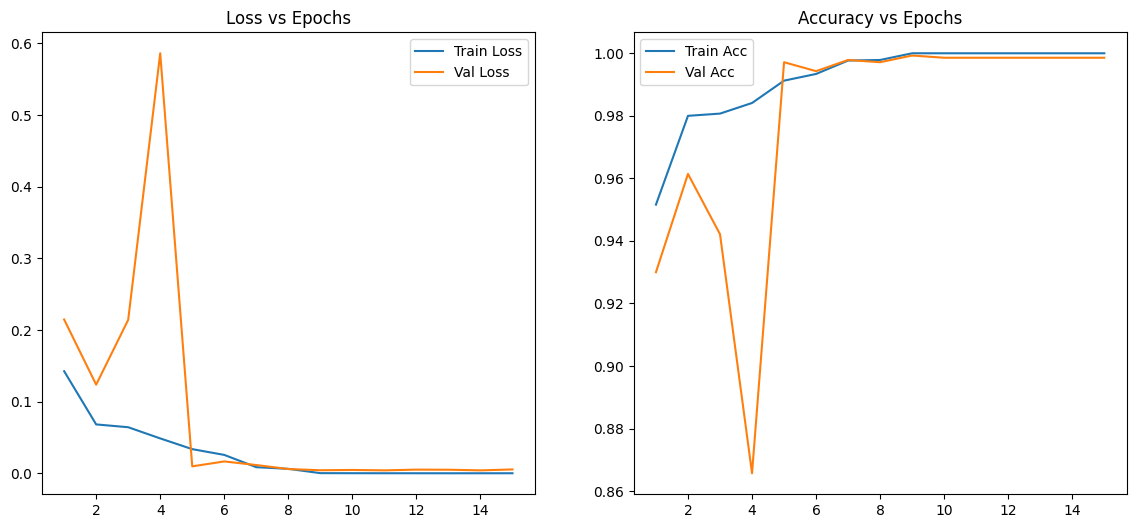

In [ ]:
#Needed
# ===========================================================
# 6. Run the training
# ===========================================================
model, label_encoder = run_cnn_training(df_train_audio, df_test_audio, batch_size=32, epochs=15)

In [ ]:
# Rebuild same model architecture first
import joblib
# label_encoder = joblib.load("res_net_label_encoder.pkl")

n_classes = 7
model_loaded = AudioResNet(n_classes)
model_loaded.load_state_dict(torch.load("best_audio_cnn.pth", map_location="cpu"))
model_loaded.eval()

AudioResNet(
  (stem): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBloc

In [ ]:
def extract_embeddings_from_df(model, df, batch_size=32, device="cuda"):
    model.eval()
    model.to(device)

    dataset = AudioFrameDataset(df)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for mel, label in loader:
            mel = mel.to(device)
            emb = model.extract_embedding(mel)
            all_embeddings.append(emb.cpu())
            all_labels.append(label)

    embeddings = torch.cat(all_embeddings, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()

    return embeddings, labels

In [ ]:
import joblib
n_classes = 7
model_loaded = AudioResNet(n_classes)
model_loaded.load_state_dict(torch.load("best_audio_cnn.pth", map_location="cpu"))
model_loaded.eval()
model=model_loaded

# Load the trained model
model.load_state_dict(torch.load("best_audio_cnn.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Extract embeddings for training set
train_embeddings, train_labels = extract_embeddings_from_df(model, df_train_audio)

# Append embeddings as a new column
df_train_audio["custom_embedding"] = list(train_embeddings)

# Extract embeddings for test set
test_embeddings, test_labels = extract_embeddings_from_df(model, df_test_audio)

# Append embeddings as a new column
df_test_audio["custom_embedding"] = list(test_embeddings)

# Check
print(df_train_audio.head())
print(df_test_audio.head())

   d1p d1v                                               path  class  domain  \
0  pat   0  train/valve_section_00_source_train_normal_000...  valve  source   
1  pat   1  train/valve_section_00_source_train_normal_000...  valve  source   
2  pat   1  train/valve_section_00_source_train_normal_000...  valve  source   
3  pat   1  train/valve_section_00_source_train_normal_000...  valve  source   
4  pat   1  train/valve_section_00_source_train_normal_000...  valve  source   

   section   label  d2p  d2v  d3p  d3v  \
0        0  normal  NaN  NaN  NaN  NaN   
1        0  normal  NaN  NaN  NaN  NaN   
2        0  normal  NaN  NaN  NaN  NaN   
3        0  normal  NaN  NaN  NaN  NaN   
4        0  normal  NaN  NaN  NaN  NaN   

                                          audio_path  dev_train_lof_anomaly  \
0  extracted_dataset/train/train/valve_section_00...                      0   
1  extracted_dataset/train/train/valve_section_00...                      0   
2  extracted_dataset/train/tr

In [ ]:
new_train_pickle_path = "/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/extracted_dataset/train_with_audio_custom.pkl"
new_test_pickle_path = "/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/extracted_dataset/test_with_audio_custom.pkl"

# Save as pickle (faster to load than CSV)
df_train_audio.to_pickle(new_train_pickle_path)
df_test_audio.to_pickle(new_test_pickle_path)

print(f"Saved train data with audio arrays at: {new_train_pickle_path}")
print(f"Saved test data with audio arrays at: {new_test_pickle_path}")

Saved train data with audio arrays at: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/extracted_dataset/train_with_audio_custom.pkl
Saved test data with audio arrays at: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/extracted_dataset/test_with_audio_custom.pkl


# Testing the Performance of Embeddings on Traditional ML Classifiers

## Naive Bayes/Decision Tree/Random Forest/SVM/KNN

In [ ]:
# Load the pickle files to work with the dataset
import pandas as pd
df_train_audio = pd.read_pickle(new_train_pickle_path)
df_test_audio = pd.read_pickle(new_test_pickle_path)

In [ ]:
df_train_audio.head()

d1p d1v                                               path  class  domain  \
0  pat   0  train/valve_section_00_source_train_normal_000...  valve  source   
1  pat   1  train/valve_section_00_source_train_normal_000...  valve  source   
2  pat   1  train/valve_section_00_source_train_normal_000...  valve  source   
3  pat   1  train/valve_section_00_source_train_normal_000...  valve  source   
4  pat   1  train/valve_section_00_source_train_normal_000...  valve  source   

   section   label  d2p  d2v  d3p  d3v  \
0        0  normal  NaN  NaN  NaN  NaN   
1        0  normal  NaN  NaN  NaN  NaN   
2        0  normal  NaN  NaN  NaN  NaN   
3        0  normal  NaN  NaN  NaN  NaN   
4        0  normal  NaN  NaN  NaN  NaN   

                                          audio_path  dev_train_lof_anomaly  \
0  extracted_dataset/train/train/valve_section_00...                      0   
1  extracted_dataset/train/train/valve_section_00...                      0   
2  extracted_dataset/train/train/valve_section_00...                      0   
3  extracted_dataset/train/train/valve_section_00...                      0   
4  extracted_dataset/train/train/valve_section_00...                      0   

   dev_train_lof_anomaly_score  add_train_lof_anomaly  \
0                     1.241023                      1   
1                     1.045440                      1   
2                     1.065896                      1   
3                     1.034885                      1   
4                     1.157675                      1   

   add_train_lof_anomaly_score  \
0                     1.806289   
1                     5.221826   
2                     5.249117   
3                     3.485701   
4                     1.733311   

                 ast-finetuned-audioset-10-10-0.4593  \
0  [[0.8152204155921936, 1.5862374305725098, -0.6...   
1  [[0.5250171422958374, 0.10363650321960449, -1....   
2  [[0.6699849367141724, 0.40861189365386963, -0....   
3  [[1.0600080490112305, 0.7144410610198975, -1.1...   
4  [[0.46108031272888184, 0.15021102130413055, -1...   

                                         audio_array  sample_rate  \
0  [-0.006225586, -0.006134033, -0.0073547363, -0...        16000   
1  [-0.0016479492, -0.00064086914, -0.003967285, ...        16000   
2  [0.01071167, 0.014038086, 0.015472412, 0.01657...        16000   
3  [-0.0040893555, -0.00289917, 0.0008544922, -0....        16000   
4  [-0.0020446777, -0.0032958984, -0.010223389, -...        16000   

                                    custom_embedding  
0  [0.21017918, 0.35244572, 0.6851236, 0.21205258...  
1  [0.35233545, 0.3532877, 1.170785, 0.052770846,...  
2  [0.32496744, 0.24322407, 1.0861204, 0.00928061...  
3  [0.23304312, 0.24801466, 1.0430704, 0.04576501...  
4  [0.17359214, 0.2927098, 0.75636834, 0.04893459...

In [ ]:
# Needed Shuffling the training and testing data to ensure anomalous samples are split evenly
import pandas as pd
import numpy as np

# Mark anomalies in test set
df_test_audio['is_anomaly'] = df_test_audio['label'] == 1  # True if anomaly

# Combine training and testing datasets
combined_df = pd.concat([df_train_audio, df_test_audio], ignore_index=True)

# Shuffle the combined dataframe
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Features and labels
X_combined = np.vstack(combined_df['custom_embedding'].values)
y_combined = combined_df['class'].values

from sklearn.decomposition import PCA

# Perform PCA and retain 90% of variance
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_combined)

print(f"Original embedding dim: {X_combined.shape[1]}, PCA dim: {X_pca.shape[1]}")

from sklearn.model_selection import train_test_split

# Stratify by class to preserve distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_combined, test_size=0.2, stratify=y_combined, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Original embedding dim: 256, PCA dim: 6
Train shape: (6720, 6), Test shape: (1680, 6)


In [ ]:
# Needed
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Define classifiers
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train & evaluate
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Macro F1-score: {macro_f1:.3f}")
    print(f"Confusion Matrix:\n{cm}\n")

=== Naive Bayes ===
Accuracy: 0.993
Macro F1-score: 0.993
Confusion Matrix:
[[240   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 238   0   0   2   0]
 [  0   0   1 233   0   6   0]
 [  0   0   0   0 238   2   0]
 [  0   0   1   0   0 239   0]
 [  0   0   0   0   0   0 240]]

=== Decision Tree ===
Accuracy: 0.997
Macro F1-score: 0.997
Confusion Matrix:
[[240   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 240   0   0   0   0]
 [  0   0   2 238   0   0   0]
 [  0   0   0   0 239   1   0]
 [  0   0   1   1   0 238   0]
 [  0   0   0   0   0   0 240]]

=== Random Forest ===
Accuracy: 0.997
Macro F1-score: 0.997
Confusion Matrix:
[[240   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 240   0   0   0   0]
 [  0   0   2 238   0   0   0]
 [  0   0   0   0 239   1   0]
 [  0   0   1   1   0 238   0]
 [  0   0   0   0   0   0 240]]

=== SVM ===
Accuracy: 0.997
Macro F1-score: 0.997
Confusion Matrix:
[[240   0   0   0   0   0   0]
 [  0 240   

In [ ]:
# -------------------------------
# Function: visualize_pca_embeddings
# -------------------------------
def visualize_pca_embeddings(df, embedding_col="custom_embedding_final", class_col="class", label_col="label",
                             n_components=2, random_state=42):
    """
    PCA visualization of embeddings.
    """
    X = np.vstack(df[embedding_col].values)
    y_class = df[class_col].values
    y_label = (df[label_col] == "anomaly").astype(int).values  # 0=normal,1=anomaly

    # Standardize and reduce
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        "PC1": X_pca[:,0],
        "PC2": X_pca[:,1],
        "Class": y_class,
        "Anomaly": y_label
    })

    plt.figure(figsize=(10,7))
    sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="Anomaly", style="Class",
                    palette=["green","red"], alpha=0.7)
    plt.title("PCA of Audio Embeddings (2D)")
    plt.show()
    plt.figure(figsize=(10,7))
    sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="Class", style="Anomaly", alpha=0.7)
    plt.title("PCA of Audio Embeddings (2D)")
    plt.show()

visualize_pca_embeddings(df_test_audio)

# Model Selection for Anomalous vs Non-Anomalous Classification - Padim(Patch Distribution Modeling)

In [ ]:
# Create the train and test images for the padim model
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import transforms as T
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from PIL import Image

OUTPUT_ROOT = "./dataset_padim_custom_resnet"
N_MELS = 128
PAD_TO_LENGTH = 768
IMG_SIZE = (128, 768)
CHANNELS = 3

def build_mel_transform(sample_rate):
    return torch.nn.Sequential(
        MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=256,
            n_mels=N_MELS
        ),
        AmplitudeToDB()
    )

def mirror_pad(mel, target_len):
    """
    mel shape = [3, n_mels, T]
    """
    T_current = mel.size(-1)

    if T_current == target_len:
        return mel

    if T_current > target_len:
        return mel[:, :, :target_len]

    pad_amount = target_len - T_current
    return F.pad(mel, (0, pad_amount), mode="reflect")

def to_pil_image_single_channel(tensor):
    """
    tensor shape: [3, H, W]
    Converts to grayscale PIL image (H, W) in mode 'L'
    """
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)
    tensor = (tensor * 255).clamp(0, 255).byte()

    tensor_np = tensor.squeeze(0).cpu().numpy()   # shape → [H, W]

    return Image.fromarray(tensor_np, mode="L")   # grayscale

def create_padim_dataset(df):
    df = df.reset_index(drop=True)
    os.makedirs(OUTPUT_ROOT, exist_ok=True)

    resize = T.Resize(IMG_SIZE)

    for idx, row in df.iterrows():
        audio = np.array(row["audio_array"], dtype=np.float32)
        sr = int(row["sample_rate"])
        class_name = str(row["class"])
        label = str(row["label"]).lower()  # "normal" or "abnormal"
        class_dir = os.path.join(OUTPUT_ROOT, class_name)
        normal_dir = os.path.join(class_dir, "normal")
        abnormal_dir = os.path.join(class_dir, "abnormal")
        os.makedirs(normal_dir, exist_ok=True)
        os.makedirs(abnormal_dir, exist_ok=True)
        audio_t = torch.tensor(audio).float().unsqueeze(0)  # [1, T]
        mel_transform = build_mel_transform(sr)
        mel = mel_transform(audio_t)
        mel = mirror_pad(mel, PAD_TO_LENGTH)
        mel = mel.repeat(CHANNELS, 1, 1)

        mel = (mel - mel.mean()) / (mel.std() + 1e-6)
        img = to_pil_image_single_channel(mel)
        img = img.convert("RGB")

        if label == "normal":
            out_path = os.path.join(normal_dir, f"{idx:06d}.jpg")
        else:
            out_path = os.path.join(abnormal_dir, f"{idx:06d}.jpg")

        img.save(out_path)

        if idx % 100 == 0:
            print(f"[{idx}/{len(df)}] Saved → {out_path}")

    print("\n Dataset generation complete!")
create_padim_dataset(combined_df)

/tmp/ipython-input-2900186983.py:68: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(tensor_np, mode="L")   # grayscale


[0/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000000.jpg
[100/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000100.jpg
[200/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000200.jpg
[300/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000300.jpg
[400/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000400.jpg
[500/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000500.jpg
[600/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000600.jpg
[700/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000700.jpg
[800/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000800.jpg
[900/8400] Saved → ./dataset_padim_custom_resnet/valve/normal/000900.jpg
[1000/8400] Saved → ./dataset_padim_custom_resnet/gearbox/normal/001000.jpg
[1100/8400] Saved → ./dataset_padim_custom_resnet/gearbox/normal/001100.jpg
[1200/8400] Saved → ./dataset_padim_custom_resnet/gearbox/normal/001200.jpg
[1300/8400] Saved → ./dataset_padim_custom_r

# Developing and training the PaDiM model with the custom Res-Net inspired CNN as the backbone [feature layers 1, 3]

In [ ]:

import torch
from pathlib import Path
from anomalib.models import Padim
from anomalib.engine import Engine
from anomalib.data import Folder
from anomalib.data.utils import ValSplitMode

results_base_path = Path("/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/")

# Load base weights once
base_weights = torch.load("best_audio_cnn_3ch.pth", map_location="cpu")

for cls in df_train_audio["class"].unique():

    print(f"\n=== Training PADIM for class: {cls} ===")
    custom_backbone = AudioResNet(n_classes=7)
    custom_backbone.load_state_dict(base_weights)

    model = Padim(
        backbone=custom_backbone,
        layers=["layer1", "layer3"],
        n_features=320
    )

    dataset_root = f"/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/dataset_padim_custom_resnet/{cls}"
    datamodule = Folder(
        name=cls,
        root=dataset_root,
        normal_dir="normal",
        abnormal_dir="abnormal",
        seed=42,
        normal_split_ratio=0.2,
        val_split_mode=ValSplitMode.FROM_TEST,
        val_split_ratio=0.5,
        train_batch_size=32,
        eval_batch_size=32,
    )

    class_result_dir = results_base_path / cls

    engine = Engine(default_root_dir=class_result_dir)

    engine.train(datamodule=datamodule, model=model)

    print(f"✓ Finished training for class {cls}")
    print(f"✓ Results stored in: {class_result_dir}")


=== Training PADIM for class: valve ===


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.4359999895095825     │
│       image_F1Score       │    0.43617022037506104    │
└───────────────────────────┴───────────────────────────┘

✓ Finished training for class valve
✓ Results stored in: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/valve

=== Training PADIM for class: gearbox ===


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6816363334655762     │
│       image_F1Score       │    0.5263158082962036     │
└───────────────────────────┴───────────────────────────┘

✓ Finished training for class gearbox
✓ Results stored in: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/gearbox

=== Training PADIM for class: ToyTrain ===


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.5770909190177917     │
│       image_F1Score       │    0.48543688654899597    │
└───────────────────────────┴───────────────────────────┘

✓ Finished training for class ToyTrain
✓ Results stored in: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyTrain

=== Training PADIM for class: bearing ===


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.708727240562439     │
│       image_F1Score       │    0.5899280309677124     │
└───────────────────────────┴───────────────────────────┘

✓ Finished training for class bearing
✓ Results stored in: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/bearing

=== Training PADIM for class: fan ===


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8539091348648071     │
│       image_F1Score       │          0.6875           │
└───────────────────────────┴───────────────────────────┘

✓ Finished training for class fan
✓ Results stored in: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/fan

=== Training PADIM for class: slider ===


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6912727355957031     │
│       image_F1Score       │     0.523809552192688     │
└───────────────────────────┴───────────────────────────┘

✓ Finished training for class slider
✓ Results stored in: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/slider

=== Training PADIM for class: ToyCar ===


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# FULL PIPELINE NOTEBOOK CELL: Audio -> CNN -> PADIM (visualize heatmaps)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.5/240.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 59.3 MB/s eta 0:00:00
  Created wheel for freia: filename=FrEIA-0.2-py3-none-any.whl size=42763 sha256=9d879e71675c266ee400d60613f894b537925a4936c50c783b8f827d185be5cf
  Stored in di

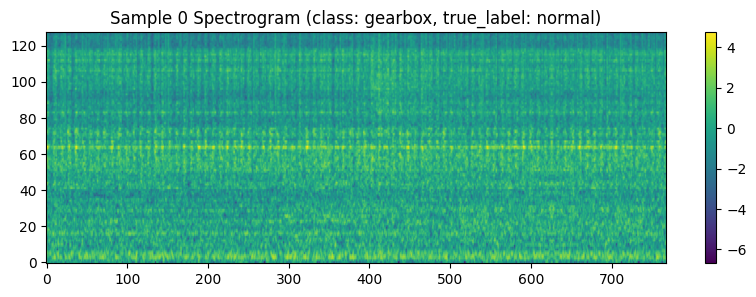

[CNN] predicted class='gearbox' idx=4 top3_probs=[1.000000e+00 1.531985e-13 7.770414e-15]
[FOUND] PADIM ckpt: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/gearbox/Padim/gearbox/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loading PADIM for gearbox from /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/gearbox/Padim/gearbox/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loaded with Padim.load_from_checkpoint
[PADIM PREDICT] Using Engine.predict with PredictDataset


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning_fabric.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/gearbox/Padim/gearbox/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning_fabric.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/gearbox/Padim/gearbox/v0/

Predicting: |          | 0/? [00:00<?, ?it/s]

[PADIM PREDICT] Engine.predict returned 1 predictions
[PADIM via Engine.predict] pred_label: tensor([True]) pred_score: tensor([[0.5289]])


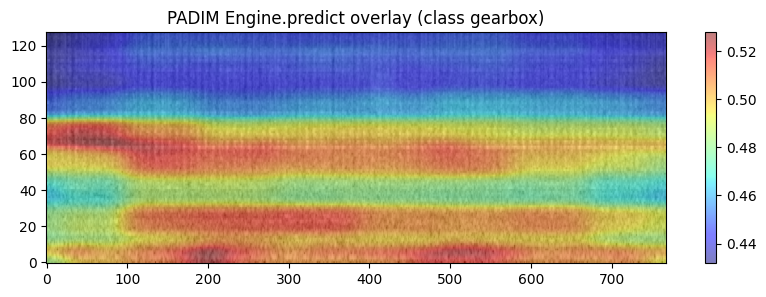


[SAMPLE 1] class=slider label=normal index_in_df=1
[DEBUG] Saved spectrogram to tmp_padim_input/sample_1_slider.png


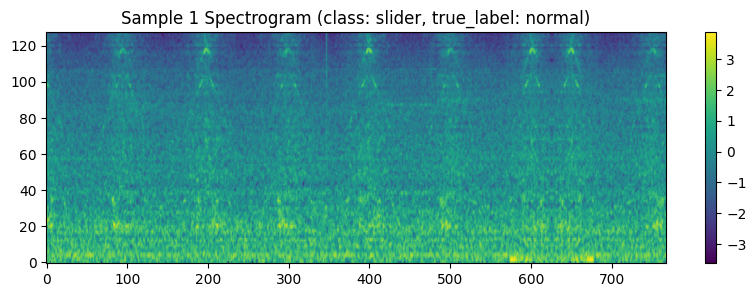

[CNN] predicted class='slider' idx=5 top3_probs=[9.9997473e-01 1.5538202e-05 5.1538018e-06]
[FOUND] PADIM ckpt: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/slider/Padim/slider/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loading PADIM for slider from /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/slider/Padim/slider/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loaded with Padim.load_from_checkpoint
[PADIM PREDICT] Using Engine.predict with PredictDataset


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning_fabric.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/slider/Padim/slider/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning_fabric.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/slider/Padim/slider/v0/weig

Predicting: |          | 0/? [00:00<?, ?it/s]

[PADIM PREDICT] Engine.predict returned 1 predictions
[PADIM via Engine.predict] pred_label: tensor([True]) pred_score: tensor([[0.6662]])


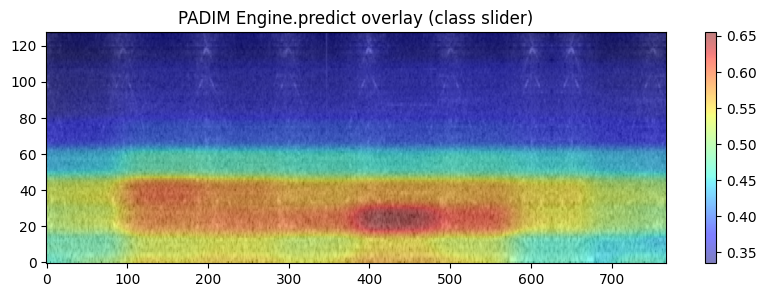


[SAMPLE 2] class=bearing label=normal index_in_df=2
[DEBUG] Saved spectrogram to tmp_padim_input/sample_2_bearing.png


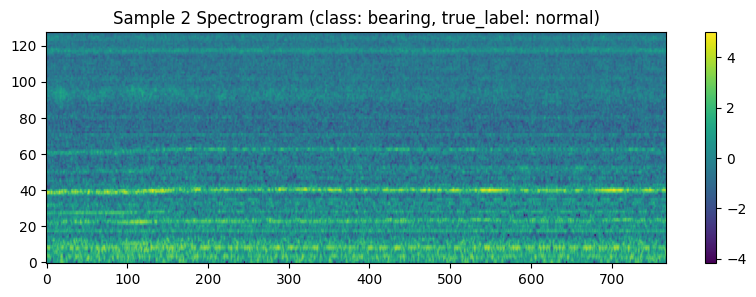

[CNN] predicted class='bearing' idx=2 top3_probs=[9.9999022e-01 6.1074934e-06 2.1613487e-06]
[FOUND] PADIM ckpt: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/bearing/Padim/bearing/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loading PADIM for bearing from /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/bearing/Padim/bearing/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loaded with Padim.load_from_checkpoint
[PADIM PREDICT] Using Engine.predict with PredictDataset


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning_fabric.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/bearing/Padim/bearing/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning_fabric.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/bearing/Padim/bearing/v0/

Predicting: |          | 0/? [00:00<?, ?it/s]

[PADIM PREDICT] Engine.predict returned 1 predictions
[PADIM via Engine.predict] pred_label: tensor([True]) pred_score: tensor([[0.5606]])


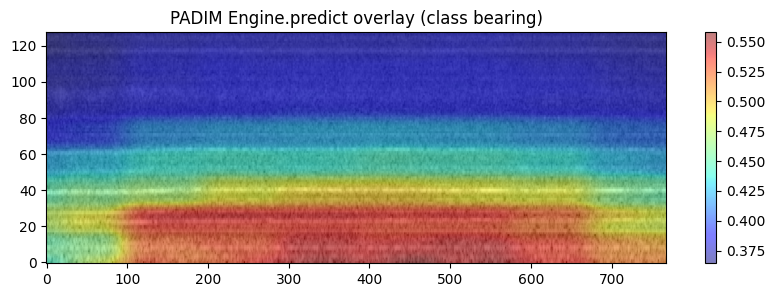


[SAMPLE 3] class=ToyCar label=anomaly index_in_df=3
[DEBUG] Saved spectrogram to tmp_padim_input/sample_3_ToyCar.png


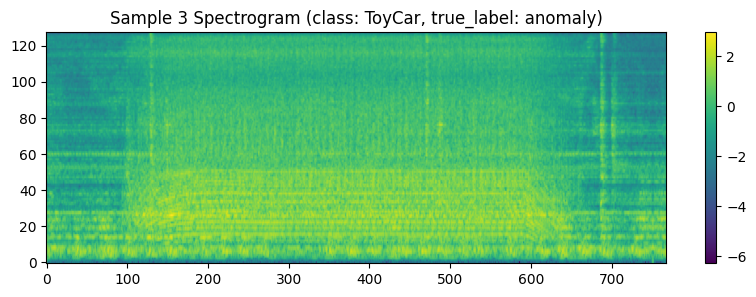

[CNN] predicted class='ToyCar' idx=0 top3_probs=[1.000000e+00 9.744556e-11 6.419963e-13]
[FOUND] PADIM ckpt: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyCar/Padim/ToyCar/v1/weights/lightning/model.ckpt
[PADIM LOAD] Loading PADIM for ToyCar from /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyCar/Padim/ToyCar/v1/weights/lightning/model.ckpt
[PADIM LOAD] Loaded with Padim.load_from_checkpoint
[PADIM PREDICT] Using Engine.predict with PredictDataset


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning_fabric.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyCar/Padim/ToyCar/v1/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning_fabric.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyCar/Padim/ToyCar/v1/weig

Predicting: |          | 0/? [00:00<?, ?it/s]

[PADIM PREDICT] Engine.predict returned 1 predictions
[PADIM via Engine.predict] pred_label: tensor([True]) pred_score: tensor([[1.]])


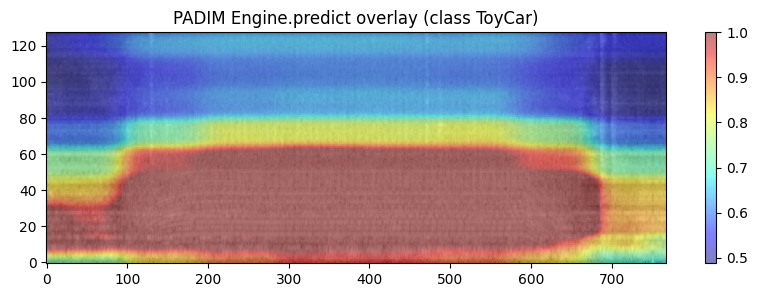


[SAMPLE 4] class=ToyTrain label=anomaly index_in_df=4
[DEBUG] Saved spectrogram to tmp_padim_input/sample_4_ToyTrain.png


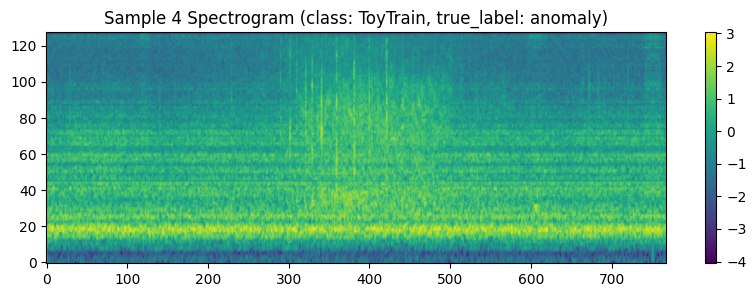

[CNN] predicted class='ToyTrain' idx=1 top3_probs=[1.0000000e+00 2.3417404e-16 1.5044532e-20]
[FOUND] PADIM ckpt: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyTrain/Padim/ToyTrain/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loading PADIM for ToyTrain from /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyTrain/Padim/ToyTrain/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loaded with Padim.load_from_checkpoint
[PADIM PREDICT] Using Engine.predict with PredictDataset


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning_fabric.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyTrain/Padim/ToyTrain/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning_fabric.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/ToyTrain/Padim/ToyTrain

Predicting: |          | 0/? [00:00<?, ?it/s]

[PADIM PREDICT] Engine.predict returned 1 predictions
[PADIM via Engine.predict] pred_label: tensor([True]) pred_score: tensor([[1.]])


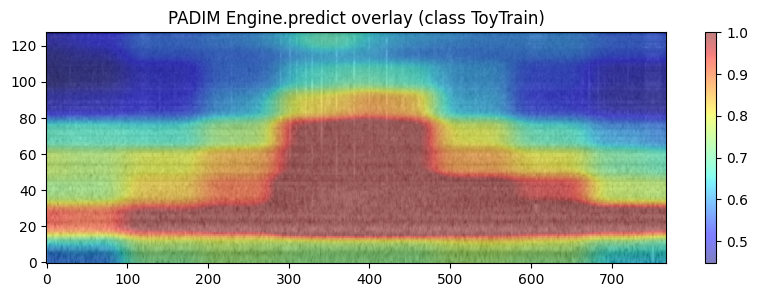


[SAMPLE 5] class=valve label=anomaly index_in_df=5
[DEBUG] Saved spectrogram to tmp_padim_input/sample_5_valve.png


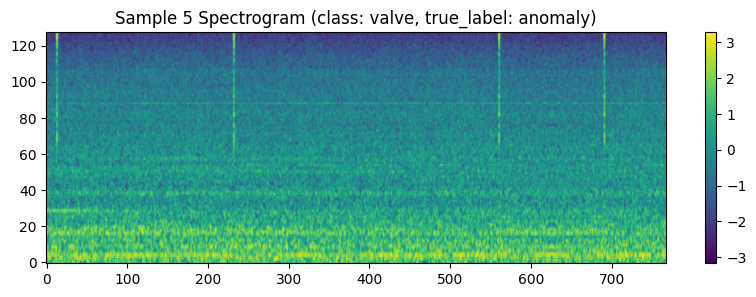

[CNN] predicted class='valve' idx=6 top3_probs=[1.000000e+00 9.071014e-11 8.136354e-11]
[FOUND] PADIM ckpt: /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/valve/Padim/valve/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loading PADIM for valve from /content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/valve/Padim/valve/v0/weights/lightning/model.ckpt
[PADIM LOAD] Loaded with Padim.load_from_checkpoint
[PADIM PREDICT] Using Engine.predict with PredictDataset


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning_fabric.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/valve/Padim/valve/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning_fabric.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/.shortcut-targets-by-id/1WIqvp-iVEF7lgpodL82Np2HHkI81rUym/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/valve/Padim/valve/v0/weights/

Predicting: |          | 0/? [00:00<?, ?it/s]

[PADIM PREDICT] Engine.predict returned 1 predictions
[PADIM via Engine.predict] pred_label: tensor([True]) pred_score: tensor([[0.8047]])


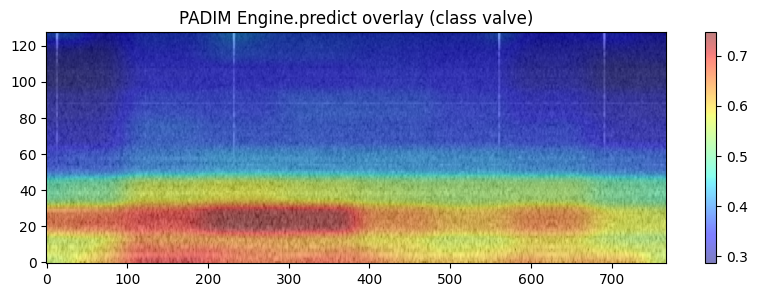

Saved results to padim_outputs/padim_inference_results_sampled.csv
Summary of the results
   sample_idx  df_index true_label pred_class  \
0           0         0     normal    gearbox   
1           1         1     normal     slider   
2           2         2     normal    bearing   
3           3         3    anomaly     ToyCar   
4           4         4    anomaly   ToyTrain   
5           5         5    anomaly      valve   

                                          padim_ckpt  anomaly_score  
0  /content/drive/MyDrive/Group Project/DCASE23_T...       0.528942  
1  /content/drive/MyDrive/Group Project/DCASE23_T...       0.666225  
2  /content/drive/MyDrive/Group Project/DCASE23_T...       0.560575  
3  /content/drive/MyDrive/Group Project/DCASE23_T...       1.000000  
4  /content/drive/MyDrive/Group Project/DCASE23_T...       1.000000  
5  /content/drive/MyDrive/Group Project/DCASE23_T...       0.804664  


In [ ]:
!pip install anomalib # Required along with the others.
# ====== FULL PIPELINE NOTEBOOK CELL: Audio -> CNN -> PADIM (visualize heatmaps) ======
#Requires: torch, torchaudio, anomalib, torchvision, skimage, matplotlib, PIL
# Please make sure the shared 'Group Project' Folder has been added as a shortcut in your home
# directory (/content/drive/MyDrive/) in drive
import os
import random
import glob
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from PIL import Image
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

# Change this path to your shared location. Make sure to add shortcut of the shared
# folder "Group Project" to the path "/content/drive/MyDrive/Group Project"
SHARED_PATH = "/content/drive/MyDrive/Group Project"

# Ensure the directory exists
os.makedirs(SHARED_PATH, exist_ok=True)

print(f"Shared path is ready at: {SHARED_PATH}")
%cd /content/drive/MyDrive/Group\ Project/DCASE23_Task2_Vehicle_Sound_Event_Detection

#  USER CONFIG
# Use the pickle files containing the entire dataset
TRAIN_PICKLE = "/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/extracted_dataset/train_with_audio_custom.pkl"
TEST_PICKLE  = "/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/extracted_dataset/test_with_audio_custom.pkl"

# Custom Audio-ResNet CNN classifier weights (3-channel model)
CNN_WEIGHTS = "best_audio_cnn_3ch.pth"

# PADIM results root (where per-class PADIM results are stored)
PADIM_RESULTS_ROOT = Path("/content/drive/MyDrive/Group Project/DCASE23_Task2_Vehicle_Sound_Event_Detection/results/Padim_Custom/")

# temporary directory to store images for PADIM's PredictDataset
TMP_IMG_DIR = Path("tmp_padim_input")
TMP_IMG_DIR.mkdir(exist_ok=True, parents=True)

# output directory for overlays + csv
OUT_DIR = Path("padim_outputs")
shutil.rmtree(OUT_DIR, ignore_errors=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# spectrogram params (must match training)
N_MELS = 128
PAD_TO_LENGTH = 768
N_FFT = 1024
HOP_LEN = 256

# inference device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#  Helper: model definitions (Custom Res-Net CNN)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class AudioResNet(nn.Module):
    def __init__(self, n_classes, n_mels=128, pad_to_length=768):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 7, 2, 3, bias=False),  # 3-channel stem (replicate grayscale)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
        )
        self.layer1 = self._make_layer(32, 64, 2, 2)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, n_classes)
    def _make_layer(self, in_c, out_c, blocks, stride):
        layers = [ResidualBlock(in_c, out_c, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_c, out_c))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.flatten(1)
        return self.fc(x)

#  Load dataframes
print("Loading dataframes...")
df_train = pd.read_pickle(TRAIN_PICKLE)
df_test  = pd.read_pickle(TEST_PICKLE)
print("Train shape:", df_train.shape, "Test shape:", df_test.shape)

# label encoder
le = LabelEncoder()
le.fit(df_train["class"].values)
classes = list(le.classes_)
print("Classes:", classes)

# spectrogram transform (single object)
mel_transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate=int(df_train['sample_rate'].iloc[0]),
                   n_fft=N_FFT, hop_length=HOP_LEN, n_mels=N_MELS),
    AmplitudeToDB()
)

def audio_to_mel_3ch(audio_array, sample_rate, pad_to=PAD_TO_LENGTH, mirror=True):
    """
    Convert 1D audio numpy -> torch tensor [3, N_MELS, pad_to]
    """
    audio_t = torch.tensor(np.array(audio_array, dtype=np.float32)).unsqueeze(0)  # [1, T]
    mel = mel_transform(audio_t)  # [1, n_mels, Tframes]
    mel = mel.squeeze(0)  # [n_mels, Tframes]
    L = mel.size(1)
    if L < pad_to:
        pad_len = pad_to - L
        if mirror:
            mel = F.pad(mel, (0, pad_len), mode="reflect")
        else:
            mel = F.pad(mel, (0, pad_len), mode="constant", value=mel.min().item())
    elif L > pad_to:
        mel = mel[:, :pad_to]
    mel = (mel - mel.mean()) / (mel.std() + 1e-6)
    # convert to 3-channel (copy)
    mel3 = mel.unsqueeze(0).repeat(3,1,1)  # [3, H, W]
    return mel3

# Load CNN model (classifier)
def load_cnn(weights_path, num_classes):
    model = AudioResNet(num_classes).to(device)
    ck = torch.load(weights_path, map_location=device)
    # handle state-dict or lightning wrapper
    if isinstance(ck, dict) and ("state_dict" in ck or "model_state_dict" in ck):
        sd = ck.get("state_dict", ck.get("model_state_dict", ck))
    else:
        sd = ck
    # try load
    try:
        model.load_state_dict(sd)
    except Exception:
        # try to strip prefixes
        sd2 = {}
        for k,v in sd.items():
            newk = k
            if newk.startswith("module."): newk = newk.replace("module.", "")
            if newk.startswith("model."): newk = newk.replace("model.", "")
            if newk in model.state_dict():
                sd2[newk] = v
        model.load_state_dict(sd2, strict=False)
        print("[WARN] loaded CNN with strict=False")
    model.eval()
    return model

print("Loading CNN classifier...")
cnn_model = load_cnn(CNN_WEIGHTS, num_classes=len(classes))
print("CNN loaded.")

#  PADIM utilities: find latest ckpt for predicted class
def find_latest_ckpt_for_class(results_root: Path, class_name: str):
    # Search inside results_root/class_name for .ckpt/.pth/.pt under any subfolders
    base = results_root / class_name
    if not base.exists():
        raise FileNotFoundError(f"No results dir for {class_name} at {base}")
    patterns = ["**/model.ckpt", "**/*.ckpt", "**/*.pth", "**/*.pt"]
    candidates = []
    for p in patterns:
        candidates.extend(list(base.glob(p)))
    if not candidates:
        raise FileNotFoundError(f"No checkpoint files found under {base}")
    candidates = sorted(candidates, key=lambda x: x.stat().st_mtime, reverse=True)
    return candidates[0]

# Cache PADIM models per-class to avoid reload
padim_model_cache = {}

# Use anomalib Engine.predict via PredictDataset if available
from anomalib.data import PredictDataset
from anomalib.engine import Engine
from anomalib.models import Padim

def load_padim_for_class(ckpt_path: Path, class_name: str, backbone_template):
    """
    Load PADIM Lightning model for class_name. Uses cache.
    backbone_template: a torch.nn.Module instance (uninitialized weights OK) to pass as backbone if needed.
    """
    if class_name in padim_model_cache:
        print(f"[PADIM CACHE] Using cached model for {class_name}")
        return padim_model_cache[class_name]
    print(f"[PADIM LOAD] Loading PADIM for {class_name} from {ckpt_path}")
    # try Padim.load_from_checkpoint first
    try:
        padim = Padim.load_from_checkpoint(str(ckpt_path), backbone=backbone_template, layers=["layer1","layer3"], n_features=320)
        padim.to(device)
        padim.eval()
        padim_model_cache[class_name] = padim
        print("[PADIM LOAD] Loaded with Padim.load_from_checkpoint")
        return padim
    except Exception as e:
        print("[PADIM LOAD] load_from_checkpoint failed:", e)
    # fallback: instantiate with backbone and load state dict manually
    try:
        padim = Padim(backbone=backbone_template, layers=["layer1","layer3"], n_features=320)
        ck = torch.load(str(ckpt_path), map_location="cpu")
        sd = ck.get("state_dict", ck.get("model_state_dict", ck))
        # strip prefixes
        sd2 = {}
        for k,v in sd.items():
            newk = k
            if newk.startswith("model."): newk = newk.replace("model.","")
            if newk.startswith("padim."): newk = newk.replace("padim.","")
            if newk in padim.state_dict():
                sd2[newk] = v
        padim.load_state_dict(sd2, strict=False)
        padim.to(device)
        padim.eval()
        padim_model_cache[class_name] = padim
        print("[PADIM LOAD] Loaded via manual state_dict (strict=False).")
        return padim
    except Exception as e:
        print("[PADIM LOAD] manual load failed:", e)
        raise RuntimeError("PADIM load failed; check checkpoint & anomalib version.")

# PADIM inference using anomalib Engine.predict on image folder
def padim_predict_from_imagefile(padim_ckpt_path: Path, image_path: str):
    """
    Use anomalib Engine.predict with PredictDataset (image path or folder).
    Returns a list of predictions (Anomalib Prediction objects).
    """
    print("[PADIM PREDICT] Using Engine.predict with PredictDataset")
    engine = Engine()
    dataset = PredictDataset(path=image_path, image_size=(256,256))
    # call engine.predict with model instance must be passed in; but Engine.predict accepts either model or model class + ckpt_path
    # anomalib Engine supports engine.predict(model=model_instance, dataset=..., ckpt_path=ckpt)
    try:
        # create a fresh model class instance without heavy backbone – we'll let engine use ckpt
        custom_backbone = AudioResNet(n_classes=7)
        custom_backbone.load_state_dict(torch.load(CNN_WEIGHTS, map_location="cpu"))
        model_stub = Padim(backbone=custom_backbone,
        layers=["layer1", "layer3"],
        n_features=320)
        predictions = engine.predict(model=model_stub, dataset=dataset, ckpt_path=str(padim_ckpt_path))
        print("[PADIM PREDICT] Engine.predict returned", len(predictions) if predictions else 0, "predictions")
        return predictions
    except Exception as e:
        print("[PADIM PREDICT] Engine.predict failed:", e)
        # fallback: load padim model and try to call predict_step on a constructed batch (handled in next helper)
        return None

# fallback inference that uses loaded padim LightningModule directly
def padim_predict_direct(padim_model, image_path: str):
    """
    Load image file, convert to tensor, call padim_model.predict_step-like interface if available,
    or try padim_model.forward / padim_model(batch_obj).
    Returns list-like of single prediction dict with keys: anomaly_map, pred_label, pred_score
    """
    from torchvision.transforms.v2 import Compose, Resize, ToTensor
    import types
    img = Image.open(image_path).convert("RGB")  # ensure 3-channel
    # apply simple transforms similar to PredictDataset: resize to 256
    transform = Compose([Resize((256,256)), ToTensor()])
    img_t = transform(img).unsqueeze(0).to(device)
    batch_obj = types.SimpleNamespace(image=img_t, label=None)
    try:
        # many anomalib modules implement predict_step(pl_module, batch, batch_idx)
        preds = padim_model.predict_step(batch_obj, 0)
        return [preds]
    except Exception as e:
        try:
            preds = padim(batch_obj)
            return [preds]
        except Exception as e2:
            print("[PADIM DIRECT] predict_step / forward both failed:", e, e2)
            return None

#  Visualization utilities
def show_spec(mel_tensor, title=None):
    # mel_tensor: torch [3,H,W]
    arr = mel_tensor.detach().cpu().numpy()
    spec = arr[0]  # grayscale repeated channel 0
    plt.figure(figsize=(10,3))
    plt.imshow(spec, origin="lower", aspect="auto")
    if title: plt.title(title)
    plt.colorbar()
    plt.show()

def show_overlay(mel_tensor, anomaly_map, title=None, alpha=0.5, cmap="jet"):
    spec = mel_tensor.detach().cpu().numpy()[0]

    # Ensure anomaly_map is a numpy array before passing to skimage.transform.resize
    if isinstance(anomaly_map, torch.Tensor):
        anomaly_map_np = anomaly_map.squeeze().detach().cpu().numpy() # Added .squeeze()
    else:
        anomaly_map_np = anomaly_map

    # resize anomaly_map to spec shape if needed
    if anomaly_map_np is None:
        print("[VIS] anomaly_map is None")
        return
    if anomaly_map_np.shape != spec.shape:
        amap_resized = resize(anomaly_map_np, spec.shape, preserve_range=True)
    else:
        amap_resized = anomaly_map_np
    plt.figure(figsize=(10,3))
    plt.imshow(spec, origin="lower", aspect="auto", cmap="gray")
    plt.imshow(amap_resized, origin="lower", aspect="auto", cmap=cmap, alpha=alpha)
    if title: plt.title(title)
    plt.colorbar()
    plt.show()

# Main processing: balanced random sampling
def run_inference_random_samples(df, n_normal=5, n_anom=5):
    # sample indices
    if 'label' not in df.columns:
        raise RuntimeError("Dataframe missing 'label' column (expected 'normal'/'anomaly')")
    normals = df[df['label'].str.lower().str.contains("normal", na=False)]
    anoms = df[df['label'].str.lower().str.contains("anom", na=False) | df['label'].str.lower().str.contains("abnorm", na=False)]
    n_normal = min(n_normal, len(normals))
    n_anom = min(n_anom, len(anoms))
    normal_samples = normals.sample(n=n_normal, random_state=42) if n_normal>0 else pd.DataFrame()
    anom_samples = anoms.sample(n=n_anom, random_state=43) if n_anom>0 else pd.DataFrame()
    combined = pd.concat([normal_samples, anom_samples]).reset_index(drop=True)
    results = []
    # cache for PADIM per-class
    padim_cache = {}
    for idx, row in combined.iterrows():
        print("\n" + "="*60)
        print(f"[SAMPLE {idx}] class={row['class']} label={row['label']} index_in_df={row.name}")
        # 1) make spectrogram and save PNG
        mel = audio_to_mel_3ch(row['audio_array'], sample_rate=int(row['sample_rate']))
        # save to tmp path
        img_path = TMP_IMG_DIR / f"sample_{idx}_{row['class']}.png"
        spec_arr = mel[0].cpu().numpy()
        plt.imsave(str(img_path), spec_arr, cmap='viridis')
        print("[DEBUG] Saved spectrogram to", img_path)
        # 2) show spectrogram
        show_spec(mel, title=f"Sample {idx} Spectrogram (class: {row['class']}, true_label: {row['label']})")
        # 3) CNN predict class
        with torch.no_grad():
            logits = cnn_model(mel.unsqueeze(0).to(device))
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            pred_idx = int(probs.argmax())
            pred_class = le.inverse_transform([pred_idx])[0]
        print(f"[CNN] predicted class='{pred_class}' idx={pred_idx} top3_probs={np.sort(probs)[-3:][::-1]}")
        # 4) find PADIM ckpt for predicted class
        try:
            ckpt = find_latest_ckpt_for_class(PADIM_RESULTS_ROOT, pred_class)
            print("[FOUND] PADIM ckpt:", ckpt)
        except Exception as e:
            print("[ERROR] could not find PADIM ckpt for class", pred_class, ":", e)
            results.append({"sample_idx": idx, "df_index": row.name, "true_label": row['label'], "pred_class": pred_class, "padim_ckpt": None, "anomaly_score": None})
            continue
        # 5) load PADIM (cached)
        if pred_class not in padim_cache:
            # prepare backbone template (we can pass a fresh AudioResNet with same architecture)
            backbone_template = AudioResNet(n_classes=len(classes))
            try:
                padim_model = load_padim_for_class(ckpt, pred_class, backbone_template)
            except Exception as e:
                print("[ERROR] PADIM load failed for", pred_class, ":", e)
                results.append({"sample_idx": idx, "df_index": row.name, "true_label": row['label'], "pred_class": pred_class, "padim_ckpt": str(ckpt), "anomaly_score": None})
                padim_cache[pred_class] = None
                continue
            padim_cache[pred_class] = padim_model
        else:
            padim_model = padim_cache[pred_class]
            if padim_model is None:
                print("[WARN] padim cached as None for", pred_class)
                results.append({"sample_idx": idx, "df_index": row.name, "true_label": row['label'], "pred_class": pred_class, "padim_ckpt": str(ckpt), "anomaly_score": None})
                continue
        # 6) Run PADIM inference.
        preds = padim_predict_from_imagefile(ckpt, str(img_path))
        prediction_obj = None
        if preds:
            prediction_obj = preds[0]
            # anomalib Prediction object typical fields: image_path, anomaly_map, pred_label, pred_score
            try:
                amap = prediction_obj.anomaly_map
            except Exception:
                # try dict-like
                amap = getattr(prediction_obj, "anomaly_map", None) or (prediction_obj.get("anomaly_map") if isinstance(prediction_obj, dict) else None)
            try:
                pred_label = prediction_obj.pred_label
                pred_score = prediction_obj.pred_score
            except Exception:
                # try dict fallback
                pred_label = getattr(prediction_obj, "pred_label", None) or (prediction_obj.get("pred_label") if isinstance(prediction_obj, dict) else None)
                pred_score = getattr(prediction_obj, "pred_score", None) or (prediction_obj.get("pred_score") if isinstance(prediction_obj, dict) else None)
            print("[PADIM via Engine.predict] pred_label:", pred_label, "pred_score:", pred_score)
            # display overlay
            if amap is not None:
                show_overlay(mel, amap, title=f"PADIM Engine.predict overlay (class {pred_class})")
            results.append({"sample_idx": idx, "df_index": row.name, "true_label": row['label'], "pred_class": pred_class, "padim_ckpt": str(ckpt), "anomaly_score": float(pred_score) if pred_score is not None else None})
            continue
        # fallback: try direct predict with loaded padim_model
        try:
            preds2 = padim_predict_direct(padim_model, str(img_path))
            if preds2:
                p = preds2[0]
                # p may be a dict or object; try extraction
                amap = p.get("anomaly_map") if isinstance(p, dict) else getattr(p, "anomaly_map", None)
                pred_label = p.get("pred_label") if isinstance(p, dict) else getattr(p, "pred_label", None)
                pred_score = p.get("pred_score") if isinstance(p, dict) else getattr(p, "pred_score", None)
                print("[PADIM direct] pred_label:", pred_label, "pred_score:", pred_score)
                if amap is not None:
                    # amap may be tensor
                    if isinstance(amap, torch.Tensor):
                        amap = amap.squeeze().cpu().numpy()
                    show_overlay(mel, amap, title=f"PADIM direct overlay (class {pred_class})")
                results.append({"sample_idx": idx, "df_index": row.name, "true_label": row['label'], "pred_class": pred_class, "padim_ckpt": str(ckpt), "anomaly_score": float(pred_score) if pred_score is not None else None})
                continue
            else:
                print("[PADIM] both Engine.predict and direct predict returned nothing")
                results.append({"sample_idx": idx, "df_index": row.name, "true_label": row['label'], "pred_class": pred_class, "padim_ckpt": str(ckpt), "anomaly_score": None})
        except Exception as e:
            print("[PADIM ERROR] failed to run prediction:", e)
            results.append({"sample_idx": idx, "df_index": row.name, "true_label": row['label'], "pred_class": pred_class, "padim_ckpt": str(ckpt), "anomaly_score": None})

    # save results CSV
    res_df = pd.DataFrame(results)
    res_df.to_csv(OUT_DIR / "padim_inference_results_sampled.csv", index=False)
    print("Saved results to", OUT_DIR / "padim_inference_results_sampled.csv")
    return res_df
    print(f"Summary of the results \n {res_df}")

# Run balanced sampling inference
res_df = run_inference_random_samples(df_test, n_normal=3, n_anom=3)
print("Summary of the results")
print(res_df)